In [1]:
import numpy as np
import re

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import ParameterVector
from qiskit.primitives import BackendEstimator, Estimator, Sampler, BackendSampler

from braket.devices import LocalSimulator
from braket.circuits import Circuit, Gate, Instruction, QubitSet, AngledGate, Observable
from braket.circuits import noises
from braket.circuits.gates import X, Rx, Rz, CNot, XY, PulseGate, U
from braket.quantum_information import PauliString
from braket.parametric import FreeParameter, FreeParameterExpression

from qiskit_braket_provider.providers import adapter
from qiskit_braket_provider import AWSBraketProvider


In [43]:
action_vector = np.random.uniform(-np.pi, np.pi, 7) # np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]) # np.random.uniform(-np.pi, np.pi, 7)

##### Parametrized qiskit circuit

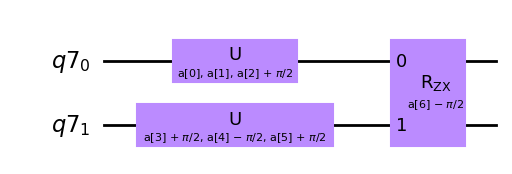

In [22]:
q_reg = QuantumRegister(2)
baseline = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
params = ParameterVector("a", 7)
qiskit_circuit = QuantumCircuit(q_reg, name="custom_cx")
# optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
optimal_params = np.pi * np.zeros(7)

qiskit_circuit.u(
    baseline[0] + params[0],
    baseline[1] + params[1],
    baseline[2] + params[2],
    q_reg[0],
)
qiskit_circuit.u(
    baseline[3] + params[3],
    baseline[4] + params[4],
    baseline[5] + params[5],
    q_reg[1],
)

qiskit_circuit.rzx(baseline[6] + params[6], q_reg[0], q_reg[1])

qiskit_circuit.draw("mpl")

#### Convert the qiskit circuit to a braket circuit

In [23]:
braket_circuit = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)
print(braket_circuit)

T  : |             0             |           1            |             2             |3|4|           5            |6|7|
                                                                                                                        
q0 : -PHASE(a2 + 1.5707963267949)-Ry(a0)-------------------PHASE(a1)---------------------C--------------------------C---
                                                                                         |                          |   
q1 : -PHASE(a5 + 1.5707963267949)-Ry(a3 + 1.5707963267949)-PHASE(a4 - 1.5707963267949)-H-X-Rz(a6 - 1.5707963267949)-X-H-

T  : |             0             |           1            |             2             |3|4|           5            |6|7|

Unassigned parameters: [a0, a1, a2, a3, a4, a5, a6].


### Run the circuit

In [24]:
device = LocalSimulator()

In [44]:
param_names = [str(param) for param in params]
# Regular expression pattern to match any of the parentheses: {}, [], ()
pattern = r'[\[\]\{\}\(\)]'

# Remove the parentheses from each string in the list
param_names = [re.sub(pattern, '', string) for string in param_names]

In [45]:
bound_parameters = dict(zip(param_names, action_vector))

In [46]:
bound_parameters

{'a0': -3.0967997864902985,
 'a1': 0.4438477469988382,
 'a2': 2.866425109034777,
 'a3': 1.7000038977106522,
 'a4': 2.783798141912297,
 'a5': 0.47395466913795126,
 'a6': 1.8022278772774305}

In [58]:
braket_circuit.instructions[0].operator.parameters[0].subs(parameter_values={'a2': 1.0})

2.57079632679490

In [48]:
# run the circuit on the local simulator
task = device.run(braket_circuit, shots=1000, inputs=bound_parameters)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'11': 977, '10': 23})


In [32]:
from sympy import sympify

In [35]:
test_expession = sympify('a0 + 1.0')

In [38]:
test_expession.evalf(subs={'a0': 1.0})

4.00000000000000

#### Test if binding of parameters works for ``FreeParameterExpression``

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


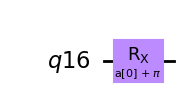

In [71]:
params = ParameterVector("a", 1)
qiskit_circuit = QuantumCircuit(QuantumRegister(1), name="test_param_binding")
qiskit_circuit.rx(np.pi + params[0], 0)

qiskit_circuit.draw("mpl")

In [72]:
braket_circ = adapter.convert_qiskit_to_braket_circuit(qiskit_circuit)
print(braket_circ)

T  : |            0            |
                                
q0 : -Rx(a0 + 3.14159265358979)-

T  : |            0            |

Unassigned parameters: [a0].


In [75]:
# run the circuit on the local simulator
task = device.run(braket_circ, shots=1000, inputs={'a0': 0.0})

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'1': 1000})
